In [1]:
from msclap import CLAP
import torch
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import pandas as pd
import os
import pickle
import matplotlib.pyplot as plt

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [2]:
df = pd.read_pickle('/work/data_pipeline/audio_data/preprocessing/web_free_source_raw/OpenSLR/SLR101/meta_metrics.pkl').dropna()
child = df[df['age'].astype(int) <= 16]
child['class'] = 'child'
#display(kids)

df = pd.read_pickle('/work/data_pipeline/audio_data/preprocessing/web_free_source_raw/OpenSLR/SLR101/meta_metrics.pkl').dropna()
adult = df[df['age'].astype(int) > 16]
adult['class'] = 'adult'
#display(adult)

In [20]:
#Create single df 
df = pd.concat([child[['filepath', 'class', 'age', 'gender']], adult[['filepath', 'class', 'age', 'gender']]])
display(df)

,filepath,class,age,gender
0,/work/data_pipeline/audio_data/preprocessing/w...,child,7,m
3,/work/data_pipeline/audio_data/preprocessing/w...,child,9,m
4,/work/data_pipeline/audio_data/preprocessing/w...,child,10,m
5,/work/data_pipeline/audio_data/preprocessing/w...,child,15,f
6,/work/data_pipeline/audio_data/preprocessing/w...,child,12,f
...,...,...,...,...
5230,/work/data_pipeline/audio_data/preprocessing/w...,adult,23,m
5233,/work/data_pipeline/audio_data/preprocessing/w...,adult,20,f
5234,/work/data_pipeline/audio_data/preprocessing/w...,adult,37,m
5241,/work/data_pipeline/audio_data/preprocessing/w...,adult,21,f


In [13]:
classes = df['class'].unique()

class_id_map = {name: i for i, name in enumerate(classes, 0)}
id_to_class = {v: k for k, v in class_id_map.items()}
print(class_id_map)

prompt = 'The speaker is the age of a:'
y = [prompt + x for x in classes]


{'child': 0, 'adult': 1}


In [5]:
# Load and initialize CLAP
clap_model = CLAP(version = '2023', use_cuda=True)

# Computing text embeddings
text_embeddings = clap_model.get_text_embeddings(y)

In [6]:
# Computing audio embeddings
y_preds, y_labels = [], []
print(os.getcwd())

for i in tqdm(range(len(df))):
    path, label, age = df.iloc[i]
    idx = class_id_map[label]
    #print(idx)
    one_hot_target = torch.nn.functional.one_hot(torch.tensor([idx]), num_classes=len(classes)+1)

    audio_embeddings = clap_model.get_audio_embeddings([path], resample=True)
    similarity = clap_model.compute_similarity(audio_embeddings, text_embeddings)

    y_pred = F.softmax(similarity.detach().cpu(), dim=1).numpy()

    y_preds.append(y_pred)
    y_labels.append(one_hot_target.detach().cpu().numpy())


/mounts/ud-data/jtaylor/a5f2c23d-7fb6-41a6-ac0c-3a2ffc02b992/data/acoustic_scene_classification/CLAP-main/examples


100%|██████████| 4999/4999 [02:06<00:00, 39.61it/s]


In [7]:
y_lab, y_pred = np.concatenate(y_labels, axis=0), np.concatenate(y_preds, axis=0)
y_label_val = np.argmax(y_lab, axis=1)
y_pred_val = np.argmax(y_pred, axis=1)
acc = accuracy_score(np.argmax(y_lab, axis=1), np.argmax(y_pred, axis=1))
print('Accuracy {}'.format(acc))

Accuracy 0.668133626725345


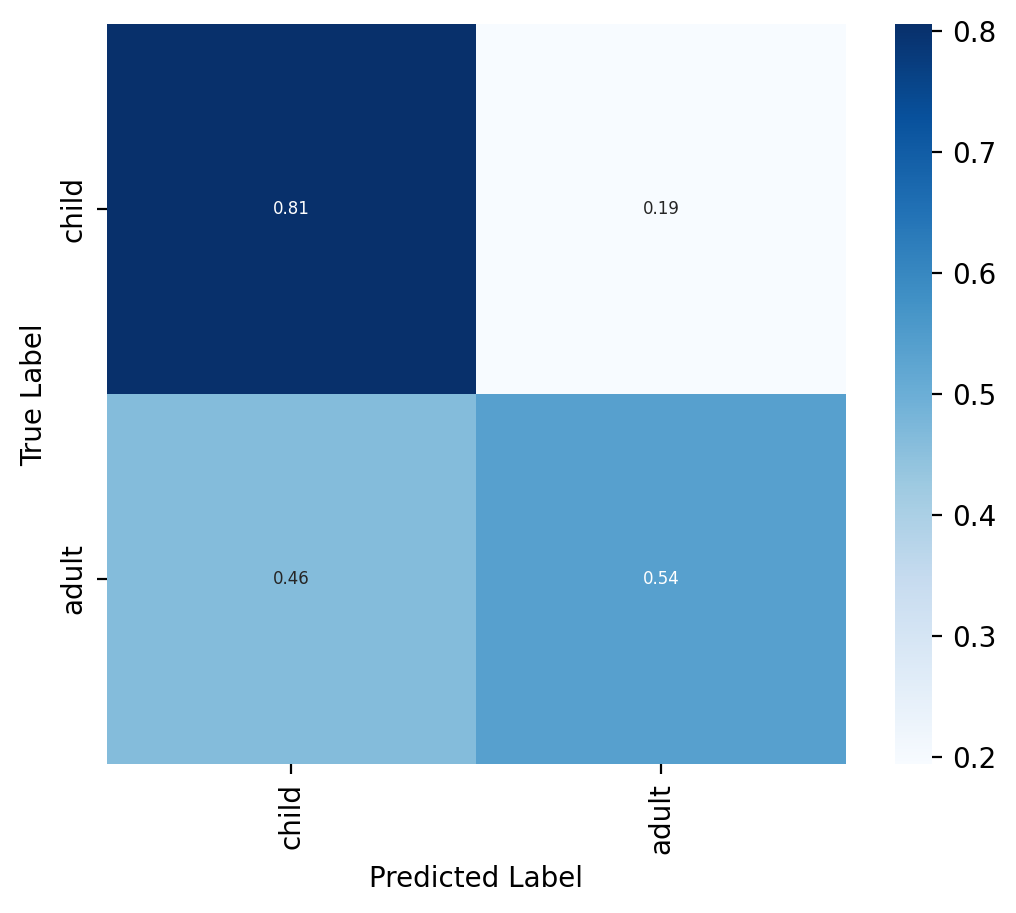

In [8]:
# get confusion matrix
conf_matrix = confusion_matrix(y_label_val,y_pred_val)
conf_mat_norm_recall = conf_matrix.astype('float32')/conf_matrix.sum(axis=1)[:,np.newaxis]
recall_by_class = np.diagonal(conf_mat_norm_recall)
mean_recall = np.mean(recall_by_class)

# Calculate row sums to use for percentages
row_sums = conf_matrix.sum(axis=1)

# Calculate percentages
percentages = (conf_matrix.T / row_sums).T  # Transpose for division, then transpose back

# Format percentages as strings with '%' symbol
annot_data = [['{:.2f}'.format(val) for val in row] for row in percentages]
annot_data = [['' if float(val <= 0.04) else '{:.2f}'.format(val) for val in row] for row in percentages]

plt.figure(dpi=200)

annot_kws = {'size': 6}
ax = sns.heatmap(percentages, xticklabels=classes, yticklabels=classes, annot=annot_data, fmt='', square=True, cmap='Blues', annot_kws=annot_kws)
ax.set_xlabel('Predicted Label')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
ax.set_ylabel('True Label')

#plt.subplots_adjust(left=0.2, bottom=0.35)
plt.show()

In [21]:
# Average for correct and incorrect
result = [a == b for a, b in zip(y_label_val, y_pred_val)]
df['predicted'] = [id_to_class[pred] for pred in y_pred_val]
df['correct'] = result

confidence = [y_preds[k][0][y_pred_val[k]] for k, pred in enumerate(y_preds)] 
df['confidence'] = confidence
display(df)

wrong_df = df[df['correct']==False]
correct_df = df[df['correct']==True]

print(np.mean(wrong_df['confidence']))
print(np.mean(correct_df['confidence']))

,filepath,class,age,gender,predicted,correct,confidence
0,/work/data_pipeline/audio_data/preprocessing/w...,child,7,m,child,True,0.966762
3,/work/data_pipeline/audio_data/preprocessing/w...,child,9,m,child,True,0.524805
4,/work/data_pipeline/audio_data/preprocessing/w...,child,10,m,adult,False,0.500750
5,/work/data_pipeline/audio_data/preprocessing/w...,child,15,f,child,True,0.789358
6,/work/data_pipeline/audio_data/preprocessing/w...,child,12,f,child,True,0.632592
...,...,...,...,...,...,...,...
5230,/work/data_pipeline/audio_data/preprocessing/w...,adult,23,m,adult,True,0.880237
5233,/work/data_pipeline/audio_data/preprocessing/w...,adult,20,f,child,False,0.519641
5234,/work/data_pipeline/audio_data/preprocessing/w...,adult,37,m,adult,True,0.778749
5241,/work/data_pipeline/audio_data/preprocessing/w...,adult,21,f,adult,True,0.834111


0.758088
0.82198375


In [22]:
predicted_as_child = df[df['predicted']=='child']
display(predicted_as_child)

,filepath,class,age,gender,predicted,correct,confidence
0,/work/data_pipeline/audio_data/preprocessing/w...,child,7,m,child,True,0.966762
3,/work/data_pipeline/audio_data/preprocessing/w...,child,9,m,child,True,0.524805
5,/work/data_pipeline/audio_data/preprocessing/w...,child,15,f,child,True,0.789358
6,/work/data_pipeline/audio_data/preprocessing/w...,child,12,f,child,True,0.632592
8,/work/data_pipeline/audio_data/preprocessing/w...,child,6,m,child,True,0.828895
...,...,...,...,...,...,...,...
5197,/work/data_pipeline/audio_data/preprocessing/w...,adult,21,f,child,False,0.841786
5203,/work/data_pipeline/audio_data/preprocessing/w...,adult,33,f,child,False,0.954465
5221,/work/data_pipeline/audio_data/preprocessing/w...,adult,22,f,child,False,0.570162
5233,/work/data_pipeline/audio_data/preprocessing/w...,adult,20,f,child,False,0.519641


In [53]:
def calc_new_class(row):
    if int(row['age']) < 11:
        return 'young child'
    else:
        return 'teenager'

In [54]:
predicted_as_child['class2'] = df.apply(calc_new_class, axis=1)
display(predicted_as_child)

,filepath,class,age,gender,predicted,correct,confidence,class2
0,/work/data_pipeline/audio_data/preprocessing/w...,child,7,m,child,True,0.966762,young child
3,/work/data_pipeline/audio_data/preprocessing/w...,child,9,m,child,True,0.524805,young child
5,/work/data_pipeline/audio_data/preprocessing/w...,child,15,f,child,True,0.789358,teenager
6,/work/data_pipeline/audio_data/preprocessing/w...,child,12,f,child,True,0.632592,teenager
8,/work/data_pipeline/audio_data/preprocessing/w...,child,6,m,child,True,0.828895,young child
...,...,...,...,...,...,...,...,...
5197,/work/data_pipeline/audio_data/preprocessing/w...,adult,21,f,child,False,0.841786,teenager
5203,/work/data_pipeline/audio_data/preprocessing/w...,adult,33,f,child,False,0.954465,teenager
5221,/work/data_pipeline/audio_data/preprocessing/w...,adult,22,f,child,False,0.570162,teenager
5233,/work/data_pipeline/audio_data/preprocessing/w...,adult,20,f,child,False,0.519641,teenager


In [55]:
classes = predicted_as_child['class2'].unique()

class_id_map = {name: i for i, name in enumerate(classes, 0)}
id_to_class = {v: k for k, v in class_id_map.items()}
print(class_id_map)

prompt = 'The speaker is a'
y = [prompt + x for x in classes]


{'young child': 0, 'teenager': 1}


In [56]:
# Load and initialize CLAP
clap_model = CLAP(version = '2023', use_cuda=True)

# Computing text embeddings
text_embeddings = clap_model.get_text_embeddings(y)

# Computing audio embeddings
y_preds, y_labels = [], []
print(os.getcwd())

for i in tqdm(range(len(predicted_as_child))):
    path, label = predicted_as_child.iloc[i][['filepath', 'class2']]
    idx = class_id_map[label]
    #print(idx)
    one_hot_target = torch.nn.functional.one_hot(torch.tensor([idx]), num_classes=len(classes)+1)

    audio_embeddings = clap_model.get_audio_embeddings([path], resample=True)
    similarity = clap_model.compute_similarity(audio_embeddings, text_embeddings)

    y_pred = F.softmax(similarity.detach().cpu(), dim=1).numpy()

    y_preds.append(y_pred)
    y_labels.append(one_hot_target.detach().cpu().numpy())

/mounts/ud-data/jtaylor/a5f2c23d-7fb6-41a6-ac0c-3a2ffc02b992/data/acoustic_scene_classification/CLAP-main/examples


100%|██████████| 3148/3148 [01:07<00:00, 46.61it/s]


In [57]:
y_lab, y_pred = np.concatenate(y_labels, axis=0), np.concatenate(y_preds, axis=0)
y_label_val = np.argmax(y_lab, axis=1)
y_pred_val = np.argmax(y_pred, axis=1)
acc = accuracy_score(np.argmax(y_lab, axis=1), np.argmax(y_pred, axis=1))
print('Accuracy {}'.format(acc))

Accuracy 0.5933926302414231


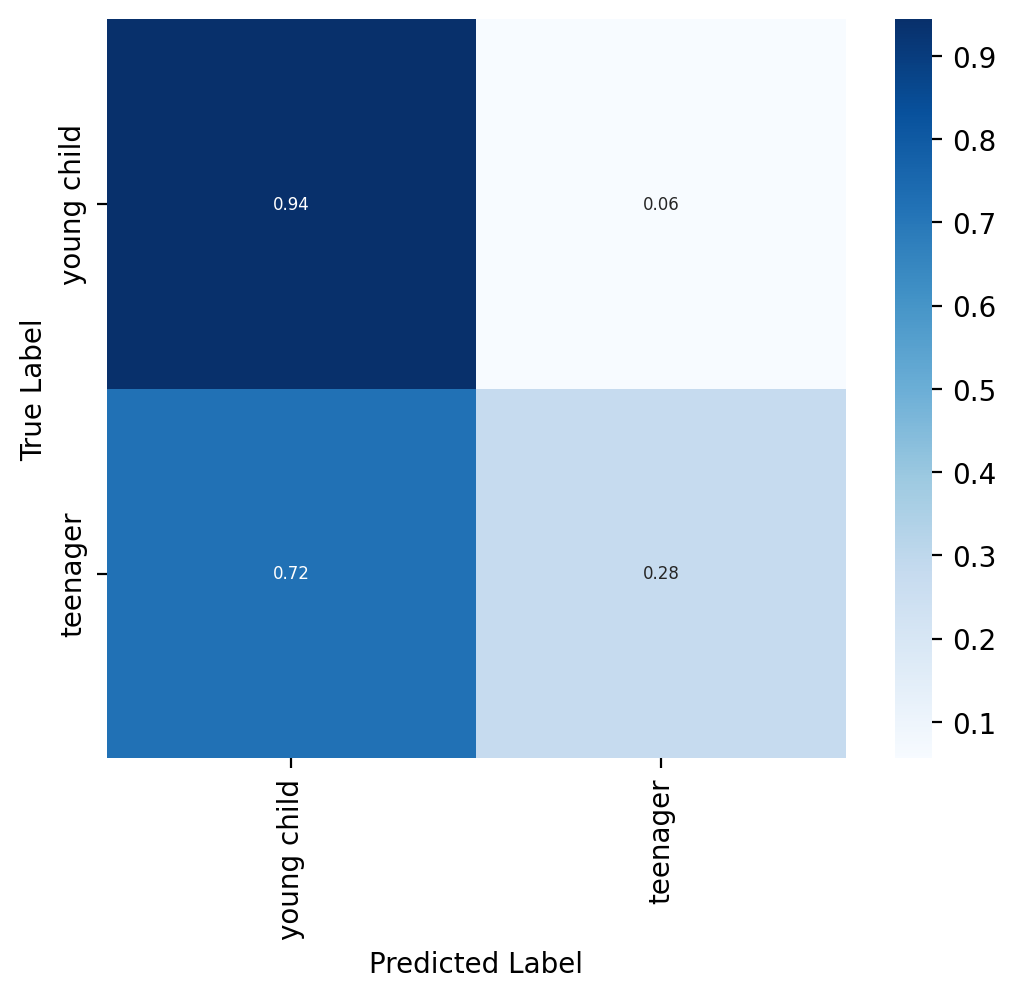

In [58]:
# get confusion matrix
conf_matrix = confusion_matrix(y_label_val,y_pred_val)
conf_mat_norm_recall = conf_matrix.astype('float32')/conf_matrix.sum(axis=1)[:,np.newaxis]
recall_by_class = np.diagonal(conf_mat_norm_recall)
mean_recall = np.mean(recall_by_class)

# Calculate row sums to use for percentages
row_sums = conf_matrix.sum(axis=1)

# Calculate percentages
percentages = (conf_matrix.T / row_sums).T  # Transpose for division, then transpose back

# Format percentages as strings with '%' symbol
annot_data = [['{:.2f}'.format(val) for val in row] for row in percentages]
annot_data = [['' if float(val <= 0.04) else '{:.2f}'.format(val) for val in row] for row in percentages]

plt.figure(dpi=200)

annot_kws = {'size': 6}
ax = sns.heatmap(percentages, xticklabels=classes, yticklabels=classes, annot=annot_data, fmt='', square=True, cmap='Blues', annot_kws=annot_kws)
ax.set_xlabel('Predicted Label')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
ax.set_ylabel('True Label')

#plt.subplots_adjust(left=0.2, bottom=0.35)
plt.show()

In [60]:
# Average for correct and incorrect
result = [a == b for a, b in zip(y_label_val, y_pred_val)]
predicted_as_child['predicted2'] = [id_to_class[pred] for pred in y_pred_val]
predicted_as_child['correct2'] = result

confidence = [y_preds[k][0][y_pred_val[k]] for k, pred in enumerate(y_preds)] 
predicted_as_child['confidence2'] = confidence
display(predicted_as_child)

wrong_df = predicted_as_child[predicted_as_child['correct']==False]
correct_df = predicted_as_child[predicted_as_child['correct']==True]

print(np.mean(wrong_df['confidence']))
print(np.mean(correct_df['confidence']))

,filepath,class,age,gender,predicted,correct,confidence,class2,predicted2,correct2,confidence2
0,/work/data_pipeline/audio_data/preprocessing/w...,child,7,m,child,True,0.966762,young child,young child,True,0.988281
3,/work/data_pipeline/audio_data/preprocessing/w...,child,9,m,child,True,0.524805,young child,young child,True,0.500758
5,/work/data_pipeline/audio_data/preprocessing/w...,child,15,f,child,True,0.789358,teenager,young child,False,0.803227
6,/work/data_pipeline/audio_data/preprocessing/w...,child,12,f,child,True,0.632592,teenager,young child,False,0.898097
8,/work/data_pipeline/audio_data/preprocessing/w...,child,6,m,child,True,0.828895,young child,young child,True,0.833344
...,...,...,...,...,...,...,...,...,...,...,...
5197,/work/data_pipeline/audio_data/preprocessing/w...,adult,21,f,child,False,0.841786,teenager,young child,False,0.798248
5203,/work/data_pipeline/audio_data/preprocessing/w...,adult,33,f,child,False,0.954465,teenager,young child,False,0.936837
5221,/work/data_pipeline/audio_data/preprocessing/w...,adult,22,f,child,False,0.570162,teenager,teenager,True,0.568529
5233,/work/data_pipeline/audio_data/preprocessing/w...,adult,20,f,child,False,0.519641,teenager,young child,False,0.593435


0.77462685
0.8733552


In [61]:
display(predicted_as_child[predicted_as_child['predicted2'] == 'teenager'])

,filepath,class,age,gender,predicted,correct,confidence,class2,predicted2,correct2,confidence2
25,/work/data_pipeline/audio_data/preprocessing/w...,child,15,f,child,True,0.535122,teenager,teenager,True,0.776003
30,/work/data_pipeline/audio_data/preprocessing/w...,child,6,f,child,True,0.539595,young child,teenager,False,0.745279
51,/work/data_pipeline/audio_data/preprocessing/w...,child,8,m,child,True,0.837273,young child,teenager,False,0.581458
77,/work/data_pipeline/audio_data/preprocessing/w...,child,11,m,child,True,0.706843,teenager,teenager,True,0.832275
106,/work/data_pipeline/audio_data/preprocessing/w...,child,15,f,child,True,0.603261,teenager,teenager,True,0.539050
...,...,...,...,...,...,...,...,...,...,...,...
5166,/work/data_pipeline/audio_data/preprocessing/w...,adult,21,f,child,False,0.615883,teenager,teenager,True,0.697444
5176,/work/data_pipeline/audio_data/preprocessing/w...,adult,25,f,child,False,0.547296,teenager,teenager,True,0.921287
5184,/work/data_pipeline/audio_data/preprocessing/w...,adult,32,m,child,False,0.725351,teenager,teenager,True,0.718277
5193,/work/data_pipeline/audio_data/preprocessing/w...,adult,26,m,child,False,0.516995,teenager,teenager,True,0.925224


In [62]:
display(predicted_as_child[predicted_as_child['class2'] == 'teenager'])

,filepath,class,age,gender,predicted,correct,confidence,class2,predicted2,correct2,confidence2
5,/work/data_pipeline/audio_data/preprocessing/w...,child,15,f,child,True,0.789358,teenager,young child,False,0.803227
6,/work/data_pipeline/audio_data/preprocessing/w...,child,12,f,child,True,0.632592,teenager,young child,False,0.898097
23,/work/data_pipeline/audio_data/preprocessing/w...,child,12,f,child,True,0.975165,teenager,young child,False,0.962019
24,/work/data_pipeline/audio_data/preprocessing/w...,child,11,f,child,True,0.953602,teenager,young child,False,0.966178
25,/work/data_pipeline/audio_data/preprocessing/w...,child,15,f,child,True,0.535122,teenager,teenager,True,0.776003
...,...,...,...,...,...,...,...,...,...,...,...
5197,/work/data_pipeline/audio_data/preprocessing/w...,adult,21,f,child,False,0.841786,teenager,young child,False,0.798248
5203,/work/data_pipeline/audio_data/preprocessing/w...,adult,33,f,child,False,0.954465,teenager,young child,False,0.936837
5221,/work/data_pipeline/audio_data/preprocessing/w...,adult,22,f,child,False,0.570162,teenager,teenager,True,0.568529
5233,/work/data_pipeline/audio_data/preprocessing/w...,adult,20,f,child,False,0.519641,teenager,young child,False,0.593435
